<a href="https://colab.research.google.com/github/MonicaKim89/Sign_Recognition/blob/main/1013_proto_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
%cd /content/drive/MyDrive/Sign Detection

/content/drive/MyDrive/Sign Detection


In [141]:
!pip install split_folders

In [142]:
from basic_preprocessing import *

from deeplearning_check import *
from machine_learning import *
from tensorflow.keras.applications import VGG16

In [143]:
gpu_check()
set_global_determinism(seed=SEED)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17582636240340358090
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11345264640
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6997182619426948413
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
tf 2.6.0
keras 2.6.0
set_global_determinism(seed=1337) 이거 꼭 해라
set_global_determinism(seed=1337) 이거 꼭 해라
set_global_determinism(seed=1337) 이거 꼭 해라


In [144]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
# from tensorflow.keras.layers.normalization import BatchNormalization
import os
import seaborn as sns

In [145]:
import joblib
model = joblib.load('/content/drive/MyDrive/Sign Detection/model/★★★0924_RF_model_96.pkl')

In [146]:
org ='/content/drive/MyDrive/Sign Detection/INPUT/box2.jpeg'
org = INPUT_IMG(org)
# show(org)
print(org.shape)

(4032, 3024, 3)


In [147]:
img = org.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
(thresh, img_bin) = cv2.threshold(gray, 128, 255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
# show(img_bin)
img_bin = 255-img_bin
# show(img_bin)

In [148]:
# Defining a kernel length
kernel_length = np.array(img).shape[1]//80
 
# A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
# A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
# A kernel of (3 X 3) ones.
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

In [149]:
# Morphological operation to detect vertical lines from an image
img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=3)
verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)
# cv2.imwrite("verticle_lines.jpg",verticle_lines_img)
# Morphological operation to detect horizontal lines from an image
img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=3)
horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)
# show(verticle_lines_img)
# show(horizontal_lines_img)

In [150]:
# Weighting parameters, this will decide the quantity of an image to be added to make a new image.
alpha = 0.5
beta = 1.0 - alpha
# This function helps to add two image with specific weight parameter to get a third image as summation of two image.
img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
(thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
# cv2.imwrite("img_final_bin.jpg",img_final_bin)Thank
# show(img_final_bin)

In [151]:
def sort_contours(cnts, method="left-to-right"):
	# initialize the reverse flag and sort index
	reverse = False
	i = 0
	# handle if we need to sort in reverse
	if method == "right-to-left" or method == "bottom-to-top":
		reverse = True
	# handle if we are sorting against the y-coordinate rather than
	# the x-coordinate of the bounding box
	if method == "top-to-bottom" or method == "bottom-to-top":
		i = 1
	# construct the list of bounding boxes and sort them from top to
	# bottom
	boundingBoxes = [cv2.boundingRect(c) for c in cnts]
	(cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
		key=lambda b:b[1][i], reverse=reverse))
	# return the list of sorted contours and bounding boxes
	return (cnts, boundingBoxes)

In [152]:
# Find contours for image, which will detect all the boxes
contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Sort all the contours by top to bottom.
(contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")

ver_images = []
idx = 0
for c in contours:
    # Returns the location and width,height for every contour
    x, y, w, h = cv2.boundingRect(c)
    if (w > 30 and h > 20) :
        idx += 1
        ver_img = img[y:y+h, x:x+w]
        ver_img = cv2.resize(ver_img,(200,200))
        ver_images.append(ver_img)
        # show(ver_img)

## **test**

In [153]:
test_images = np.array(ver_images.copy())
test_images = test_images / 255.0
x_test = test_images

from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import VGG16

In [154]:
#Load model wothout classifier/fully connected layers
SIZE = 200
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
# VGG_model.summary()  #Trainable parameters will be 0

In [155]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

prediction_RF = model.predict(X_test_features)
confidence = model.predict_proba(X_test_features)
# print(prediction_RF)
#Inverse le transform to get original label back. 
# prediction_RF = le.inverse_transform(prediction_RF)
# print(prediction_RF)

fragile confidence:  0.88


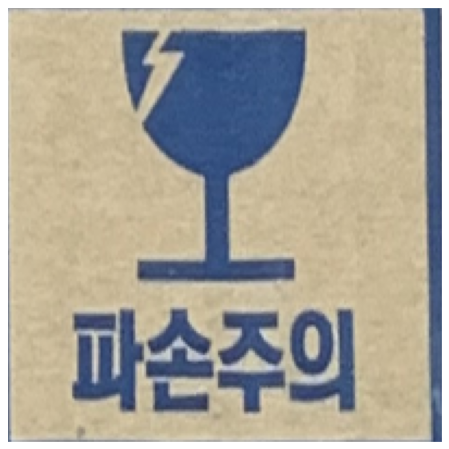

fragile confidence:  0.64


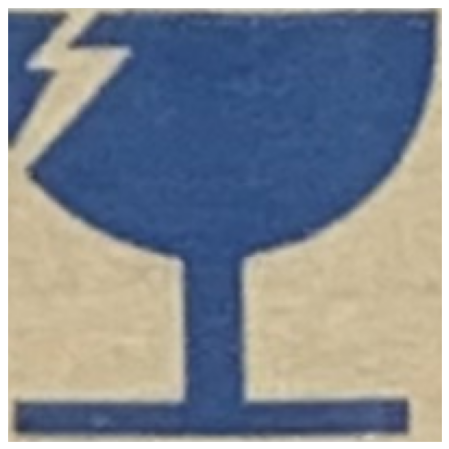

wet confidence 0.62


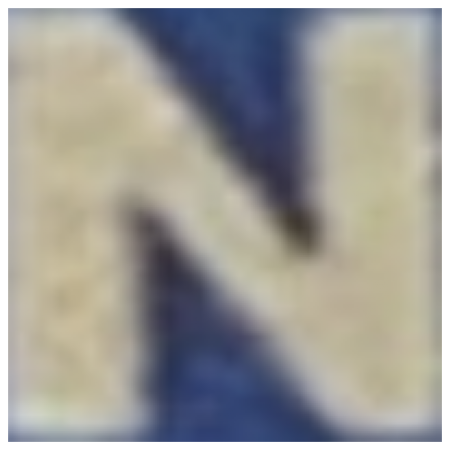

In [157]:
 for i in range(len(x_test)):
    #Check results on a few select images
    categories= ['fragile','handle','up','wet']
    img = x_test[i]
    input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
    input_img_feature=VGG_model.predict(input_img)
    input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
    prediction_RF = model.predict(input_img_features)[0] 
    confidence = model.predict_proba(input_img_features)
    for conf in confidence:
        fragile,handle,up,wet= conf
        if fragile>=0.6:
            print('fragile confidence: ', fragile)
            show(x_test[i])
        elif handle>=0.6:
            print('handle confidence', handle)
            show(x_test[i])
        elif up>=0.6:
            print('up confidence', up)
            show(x_test[i])
        elif wet>=0.6:
            print('wet confidence', wet)
            show(x_test[i])
        # else:
            # print('not detected')
            # show(x_test[i])

    # # prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
    # print("The prediction for this image is: ", categories[prediction_RF], prediction_RF)
    # print('Cofidence: ', confidence)
    # show(x_test[i])
    # print('-------------------------------------------------')
    # # print("The actual label for this image is: ", test_labels[n])